In [186]:
import pandas as pd
import sympy as sp
import math as mt
import numpy as np
import matplotlib.pyplot as plt

### Modelamiento final de la función V(t)

#### Truncamiento de cifras decimales

In [155]:
def truncar(numero, decimales):
    """   
    :numero: El número a truncar
    :param decimales: Cuántos decimales mantener
    :return: número truncado en número n de decimales, ejemplo: original= 0.335, 0.33 a 2 decimales truncados
    """
    factor = 10 ** decimales
    return mt.trunc(numero * factor) / factor

#### Obtener los coeficientes de la función que se obtendrá mediante el método de Mínimos Cuadrados

In [156]:
def coeficientes_minimos_cuadrados_general(func_str, t_lista, y_lista, valores_iniciales):
    """
    :param func_str: string, función base para el modelado
    :param x_lista: lista de valores de t
    :param y_lista: lista de valores de y
    :param valores_iniciales: lista con valores iniciales, ej: [1, 0.1]
    :return: diccionario {a: valor_est, b: valor_est, ...}
    """
    f = sp.sympify(func_str)

    simbolos = list(f.free_symbols) #Obtiene las variables independientes y coeficientes de la función

    t = sp.Symbol('t')
    if t not in simbolos:
        raise ValueError("La función debe contener el símbolo 't' como variable independiente.")
    
    parametros = [s for s in simbolos if s != t] #Filtra y guarda únicamente los coeficientes

    if len(parametros) != len(valores_iniciales):
        raise ValueError("El número de valores iniciales debe coincidir con el número de parámetros.")

    S = 0
    #Lógica para las derivadas parciales y resolucion del sistema de ecuaciones
    for ti, yi in zip(t_lista, y_lista):
        S += (yi - f.subs(t, ti))**2

    ecuaciones = [sp.diff(S, p) for p in parametros]

    solucion = sp.nsolve(ecuaciones, parametros, valores_iniciales, tol=1e-8)

    return {str(parametros[i]): float(solucion[i]) for i in range(len(parametros))} #Crea diccionario con las soluciones

#### Convertir la función obtenida como un modelo simbólico

In [157]:
def minimos_cuadrados_general_simbolico(func_str, coeficientes, decimales):
    """
    :param func_str: string, función original
    :param coeficientes: diccionario, valor de los coeficientes de la función
    :param decimales: entero, número de decimales a truncar
    :return: string con la función y sus respectivos coeficientes truncados según decimales
    """
    for clave, valor in coeficientes.items():
        func_str = func_str.replace(str(clave), str(truncar(valor, decimales)))   
    return func_str

#### Convertir la función obtenida como un modelo numérico

In [158]:
def minimos_cuadrados_general_numerico(func_str, coeficientes):
    """
    :param func_str: string, función original
    :param coeficientes: lista con los coeficientes del modelo
    :return: función lambda, capaz de realizar operaciones del tipo f(arg), donde arg es un valor y f devuelve otro
    """
    t = sp.Symbol("t")
    func_num = sp.sympify(func_str)
    func_num = func_num.subs(coeficientes)
    return sp.lambdify(t, func_num, "numpy")

In [159]:
def crear_modelo(entrada, modelo_base):
    try:
        df = pd.read_csv("datos_ajuste.csv")
    except FileNotFoundError:  # Archivo no encontrado
        print("Archivo no encontrado:", entrada)  # Mensaje de error
        return None
    except Exception as e:  # Captura de otro tipo de errores
        print("Error al leer el CSV:", e)  # Mensaje de error
        return None
    
    datos_t = [i + 1 for i in range(len(df))]
    datos_y = df['sales_week'].tolist()
    valores_iniciales = [0] * len([s for s in list(sp.sympify(modelo_base).free_symbols) if s !=sp.Symbol('t')])
    coeficientes = coeficientes_minimos_cuadrados_general(modelo_base, datos_t, datos_y, valores_iniciales)
    return minimos_cuadrados_general_numerico(modelo_base, coeficientes), minimos_cuadrados_general_simbolico(modelo_base, coeficientes, 5)

In [160]:
v_real, modelo_simbolico = crear_modelo("datos_ajuste.csv", "a*t+b")
print("Modelo de la función V(t) mediante Mínimos Cuadrados")
print(f"{modelo_simbolico}")

Modelo de la función V(t) mediante Mínimos Cuadrados
4957.04751*t+313743.88309


### Simulación del modelo

#### Creación de la función

$$f(t) = V_{real}(t) - V_{meta}$$

In [161]:
def f(t, v_meta):
    return v_real(t) - v_meta

#### Obtener el intervalo en donde se realizará la predicción

In [162]:
def encontrar_intervalo(v_meta, t_ini=195, t_fin=242, eps=1e-3):
    """
    Busca intervalo (t, t+1) con cambio de signo para f(t, v_meta),
    pero también detecta si ya estás cerca de la raíz (|f|<eps).
    """
    fa = f(t_ini, v_meta)
    if abs(fa) < eps:
        return (t_ini, t_ini)
    for t in range(t_ini, t_fin):
        fb = f(t + 1, v_meta)
        if abs(fb) < eps:
            return (t + 1, t + 1)
        if fa * fb < 0:
            return (t, t + 1)
        fa = fb
    return None

#### Método de la Bisección

In [163]:
def biseccion(a, b, v_meta, TOL=1e-3, N_0=100):
    """
    Método de Bisección para hallar t tal que f(t, v_meta)=0

    :param a: punto inicial del intervalo (float/int)
    :param b: punto final del intervalo (float/int)
    :param v_meta: meta de ventas (float/int)
    :param TOL: float, tolerancia
    :param N_0: int, número máximo de iteraciones
    :return: aproximación p de la raíz, o None si no aplica/fracasa
    """
    if a > b:
        return None
    fa = f(a, v_meta)
    fb = f(b, v_meta)
    if fa == 0:
        return a
    if fb == 0:
        return b
    if fa * fb > 0:
        return None
    i = 1
    while i <= N_0:
        p = (a + b) / 2.0
        fp = f(p, v_meta)
        if fp == 0 or (b - a) / 2.0 < TOL:
            return p
        if fa * fp > 0:
            a = p
            fa = fp
        else:
            b = p
            fb = fp
        i += 1
    return None

In [164]:
v_meta = 1362405
intervalo = encontrar_intervalo(v_meta)
if intervalo is None:
    print ("No existe un cambio de signo, no se puede predecir sobre esa meta")
else:
    a, b = intervalo
    t_sol_bi = biseccion(a, b, v_meta, TOL=1e-3, N_0=100)
    print(f"Las semanas en donde se ha encontrado cambio de signo es: [{a},{b}]")
    print(f"Semana estimada (bisección): {t_sol_bi}")

Las semanas en donde se ha encontrado cambio de signo es: [211,212]
Semana estimada (bisección): 211.5498046875


### Método de Newton - Raphson

#### Obtener la derivada de la función

In [165]:
def f_derivada(t, v_meta, h=1e-5):
    """
    Aproxima f'(t) con diferencias centrales:
    f'(t) ≈ (f(t+h) - f(t-h)) / (2h)
    """
    return (f(t + h, v_meta) - f(t - h, v_meta)) / (2.0 * h)

#### Calcular la semana estimada con el método de Newton - Raphson

In [166]:
def newton(p_0, meta, TOL=1e-3, N_0=100):
    """
    :param p_0: aproximación inicial
    :param TOL: float, tolerancia
    :param N_0: entero, número de iteraciones
    :return: aproximación p de la raíz de la función o mensaje de error
    """
    i = 1
    i_fallidos = 0
    while i <= N_0:
        p=p_0 - f(p_0, meta)/f_derivada(p_0, meta)
        if abs(p - p_0)<TOL:
            return p
        i += 1
        i_fallidos += 1
        p_0 = p
    return None

In [167]:
p_0 = (a + b) / 2
t_sol_ne = newton(p_0, v_meta)
if t_sol_ne is None:
    print ("No se pudo hallar una aproximación para esa meta")
else:
    print(f"Semana estimada (newton): {t_sol_ne}")

Semana estimada (newton): 211.54953898355993


#### Probar con una lista de metas

In [168]:
def simular_metas(lista_metas, t_ini=195, t_fin=242, tol=1e-3):
    resultados = {}
    for Vmeta in lista_metas:
        intervalo = encontrar_intervalo(Vmeta, t_ini=t_ini, t_fin=t_fin)
        if intervalo is None:
            resultados[Vmeta] = {
                "v_meta": Vmeta,
                "t_bis": None,
                "t_new": None
            }
            continue
        a, b = intervalo
        t_bis = biseccion(a, b, Vmeta, tol)
        t_new = newton(p_0, Vmeta, tol)
        resultados[Vmeta] = {
            "v_meta": Vmeta,
            "t_bis": t_bis,
            "t_new": t_new
        }
    return resultados

In [169]:
meta_venta_agresiva = 1500000
meta_venta_conservadora = 1300000
resultados = simular_metas([meta_venta_agresiva, meta_venta_conservadora])
for keys, values in resultados.items():
    print(values)

{'v_meta': 1500000, 't_bis': 239.3076171875, 't_new': 239.30698926680873}
{'v_meta': 1300000, 't_bis': 198.9599609375, 't_new': 198.96039195840538}


#### Error de ventas

error_meta = $|y_{real}(round(\hat{t})) - v_{meta}|$

#### Crear archivo con columnas desde el 194 hasta 242

In [181]:
def error_meta(t_hat):
    df_val = pd.read_csv("datos_validacion.csv")
    df_val = df_val.copy()
    df_val["week_end"] = pd.to_datetime(df_val["week_end"], errors="coerce")
    inicio = 194
    df_val["week_num"] = np.arange(inicio, inicio + len(df_val))
    t_round = int(round(t_hat))
    y_real = df_val.loc[df_val["week_num"] == t_round, 'sales_week'].iloc[0]
    error_meta_abs = abs(y_real - v_meta)
    error_meta_rel = error_meta_abs / abs(v_meta) * 100
    return error_meta_rel

#### Calculamos el error relativo porcentual entre las ventas de la semana real y de la semana aproximada

In [185]:

t_bis_agr = resultados[1500000]['t_bis']
print(error_meta(t_bis_agr))
t_bis_cons = resultados[1300000]['t_bis']
print(error_meta(t_bis_cons))
t_new_agr = resultados[1500000]['t_new']
print(error_meta(t_new_agr))
t_new_cons = resultados[1300000]['t_new']
print(error_meta(t_new_cons))

0.07530800312682352
18.412806764508353
0.07530800312682352
18.412806764508353


#### Gráfica del modelo

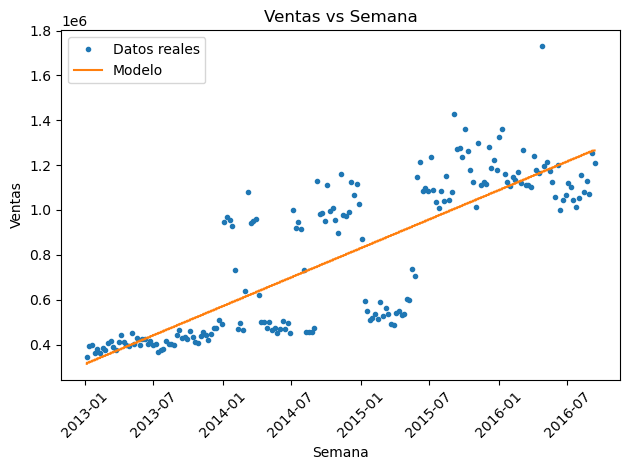

In [200]:

def graficar_puntos_y_funcion(entrada, f):
    df = pd.read_csv(entrada)
    df["week_end"] = pd.to_datetime(df["week_end"])

    x = np.arange(len(df))
    y = df["sales_week"].values

    x_fino = np.linspace(x.min(), x.max(), 1000)
    y_fino = f(x_fino)

    plt.figure()
    plt.plot(df["week_end"], y, '.', label="Datos reales")
    plt.plot(df["week_end"].iloc[x_fino.astype(int)], y_fino, label="Modelo")

    plt.title("Ventas vs Semana")
    plt.xlabel("Semana")
    plt.ylabel("Ventas")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

graficar_puntos_y_funcion("datos_ajuste.csv", v_real)

#### MAPE

In [209]:
def calcular_mape():
    df_val = pd.read_csv("datos_validacion.csv")
    df_val = df_val.copy()
    df_val["week_end"] = pd.to_datetime(df_val["week_end"], errors="coerce")
    inicio = 194
    df_val["week_num"] = np.arange(inicio, inicio + len(df_val))
    errores = []
    for _, fila in df_val.iterrows():
        t = fila["week_num"]                 # semana
        y_real = fila["sales_week"]          # venta real
        y_hat = v_real(t)                         # venta estimada por el modelo

        # Evitar división por cero
        if y_real != 0:
            ape = abs(y_real - y_hat) / abs(y_real) * 100
            errores.append(ape)

    if len(errores) == 0:
        return None

    return np.mean(errores)

In [210]:
mape = calcular_mape()
print(f"MAPE del modelo en validación: {mape:.4f}%")

MAPE del modelo en validación: 15.4986%


#### Criterio del 80% de las semanas de validación menores al 20%

In [213]:
def criterio_80_20():
    df_val = pd.read_csv("datos_validacion.csv")
    df_val = df_val.copy()
    df_val["week_end"] = pd.to_datetime(df_val["week_end"], errors="coerce")
    inicio = 194
    df_val["week_num"] = np.arange(inicio, inicio + len(df_val))
    cumple = 0
    total = 0

    for _, fila in df_val.iterrows():
        t = fila["week_num"]
        y_real = fila["sales_week"]
        y_hat = v_real(t)

        if y_real != 0:
            ape = abs(y_real - y_hat) / abs(y_real) * 100
            total += 1
            if ape < 20:
                cumple += 1

    if total == 0:
        return None

    porcentaje = cumple / total * 100
    return porcentaje

In [214]:
porcentaje_ok = criterio_80_20()
print(f"{porcentaje_ok:.2f}% de las semanas tienen APE < 20%")

87.76% de las semanas tienen APE < 20%
